In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import neurospyke as ns
import h5py
from scipy.io import savemat
from scipy.signal import savgol_filter, butter, lfilter
import matplotlib.pyplot as plt
import os
import shutil
import preprocessing
import json

In [2]:
f = open('settings.json')
settings = json.load(f)
f.close()

sampling_frequency = settings['sampling_frequency']
sampling_time = 1 / sampling_frequency
signal_duration = settings['signal_duration']

group = settings['group']
subject = settings['subject']
conditions = settings['conditions']
areas = list(settings['areas'].keys())
n_channels = settings['n_channels']
n_stimuli = settings['n_stimuli']

raw_data_paths = preprocessing.get_raw_data_paths(group, subject, conditions[0], areas)

In [3]:
# Stimulus Detection
stimulus_idxs_matrix = preprocessing.get_stimulus_idxs_matrix(raw_data_paths, conditions[0], settings)
stimulus_idxs = preprocessing.get_median_stimulus_idxs(stimulus_idxs_matrix, tolerance_duration=0.1, settings=settings)

In [4]:
# Analysis on a single channel, given the stimulus_idxs computed above
f = h5py.File(os.path.join('./data', group, subject, conditions[0], 'Raw_P1_Ch_000.mat'))

data = f['data'][:]
data = np.reshape(data, np.size(data))
data = data[np.arange(0, signal_duration * sampling_frequency)]
raw_data = np.copy(data)

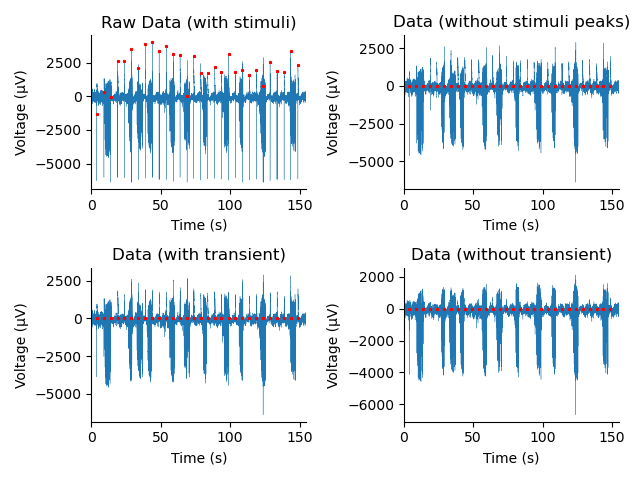

In [5]:
# SALPA
data = np.copy(raw_data)
_, ax = plt.subplots(2, 2)

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[0][0], sampling_time=sampling_time, title='Raw Data (with stimuli)')

stimulus_samples = 160 # samples
stimulus_half_samples = int(np.ceil(stimulus_samples / 2))
stimulus_range = np.arange(-stimulus_half_samples, stimulus_half_samples)

transient_duration = 0.7 # seconds
transient_samples = int(np.ceil(transient_duration * sampling_frequency))
transient_range = np.arange(stimulus_half_samples, stimulus_half_samples + transient_samples)
transients = []

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + stimulus_range] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[0][1], sampling_time=sampling_time, title='Data (without stimuli peaks)')

mean_transient = np.mean(transients, 0)
# ns.visualization.plot_raw_data(mean_transient)

zero_idx = np.where(mean_transient >= 0)[0][0]
extended_stimulus_range = np.arange(stimulus_half_samples, stimulus_half_samples + zero_idx)
transients = []

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + extended_stimulus_range] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[1][0], sampling_time=sampling_time, title='Data (with transient)')

mean_transient = np.mean(transients, 0)
mean_transient_smoothed = savgol_filter(mean_transient, 2001, 2)
# ns.visualization.plot_raw_data(mean_transient)

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + transient_range] = data[stimulus_idx + transient_range] - mean_transient_smoothed

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax[1][1], sampling_time=sampling_time, title='Data (without transient)')

plt.tight_layout()

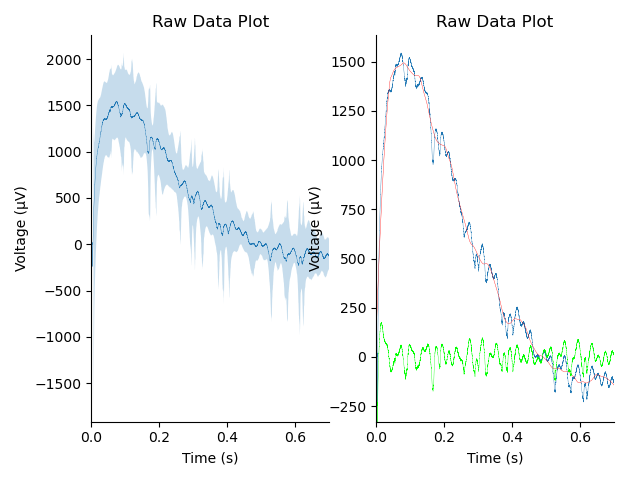

In [6]:
# Check SALPA transient
_, ax = plt.subplots(1, 2)

transient_std = np.std(transients, 0)
ax[0].fill_between(transient_range * sampling_time, mean_transient - transient_std, mean_transient + transient_std, alpha=0.25)
ns.visualization.plot_raw_data(mean_transient, ax=ax[0], sampling_time=sampling_time)
plt.tight_layout()

ns.visualization.plot_raw_data(mean_transient, ax=ax[1], sampling_time=sampling_time)
ns.visualization.plot_raw_data(mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#FF0000')
ns.visualization.plot_raw_data(mean_transient - mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#00FF00')

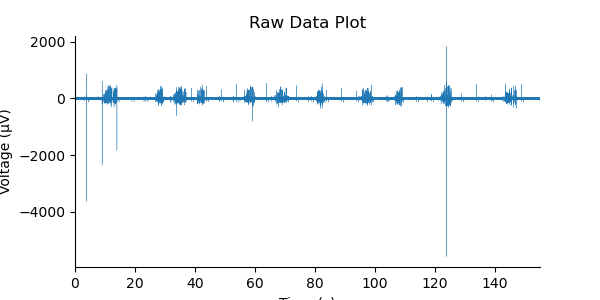

In [7]:
num, den = butter(2, [300, 7000], btype='bandpass', fs=sampling_frequency)
filtered_data = lfilter(num, den, data)

ns.visualization.plot_raw_data(filtered_data, sampling_time=sampling_time)

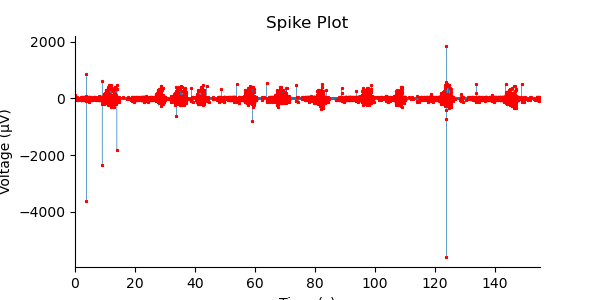

In [8]:
from scipy.stats import median_abs_deviation
threshold = 4*1.4824*median_abs_deviation(filtered_data)
spikes_idxs, _ = ns.spikes.hard_threshold_local_maxima(filtered_data, threshold, 0.001, use_abs=True, sampling_time=sampling_time)

ns.visualization.plot_spikes(filtered_data, spikes_idxs, sampling_time=sampling_time)

C:\Users\Francesco\AppData\Local\Temp\ipykernel_23896\2637848005.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  spikes_idxs = np.delete(spikes_idxs, stimulus_idxs + transient_samples)


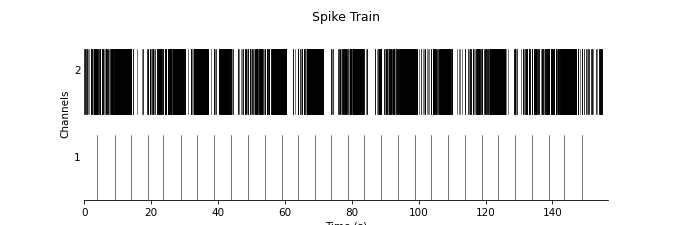

In [9]:
# ns.visualization.plot_spike_train([spikes_idxs, stimulus_idxs], channel_labels=['Spikes', 'Stimuli'], color=['#000000', '#FF0000'], linewidth=0.15, sampling_time=sampling_time, figsize=(9, 1), dpi=100)

save_path = './temp'
if os.path.isdir(save_path):
    shutil.rmtree(save_path)

os.mkdir(save_path)

spikes_idxs = np.delete(spikes_idxs, stimulus_idxs + transient_samples)
ns.visualization.plot_spike_train([stimulus_idxs, spikes_idxs], sampling_time=sampling_time, figsize=(9, 3), dpi=75)
spike_train = ns.utils.convert_spikes_idxs_to_spike_train(spikes_idxs, sampling_time, 155)


In [ ]:
savemat(os.path.join(save_path, 'preprocessed_data' + '.mat'), {'spike_train': spike_train, 'stimulus_idxs': stimulus_idxs})